In [1]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

import tmclient

%matplotlib inline

In [2]:
# Load in all csv result files & combine them to one pandas table
wells = ['B' + '{0:02d}'.format(x) for x in range(2,7)] + \
        ['C' + '{0:02d}'.format(x) for x in range(2,7)] + \
        ['E' + '{0:02d}'.format(x) for x in range(2,7)]

base_path_features = '/Users/Joel/shares/workShareJoel/20190702-StainingTest1/feature-values_SVMs/20190702-StainingTest1_p1_'
base_path_metadata = '/Users/Joel/shares/workShareJoel/20190702-StainingTest1/feature-values_SVMs/20190702-StainingTest1_p1_'
base_path_popcon = '/Users/Joel/shares/workShareJoel/20190702-StainingTest1/popcon_features/20190702-StainingTest1_p1_'
base_path_edge = '/Users/Joel/shares/workShareJoel/20190702-StainingTest1/popcon_features/20190702-StainingTest1_p1_'

results = pd.DataFrame()

for well in wells:
    curr_features = pd.read_csv(base_path_features + well + '_Nuclei_feature-values.csv')
    curr_metadata = pd.read_csv(base_path_metadata + well + '_Nuclei_metadata.csv')
    curr_popcon = pd.read_csv(base_path_popcon + well + '_Nuclei_popcon.csv')
    curr_edge = pd.read_csv(base_path_edge + well + '_Nuclei_edge.csv')
    curr_well_tmp = curr_features.merge(curr_metadata, on = ['mapobject_id'])
#     results = pd.concat([results, curr_well_tmp])
    curr_well2 = curr_well_tmp.merge(curr_popcon, on = ['mapobject_id'])
    curr_well = curr_well2.merge(curr_edge, on = ['mapobject_id'])
    results = pd.concat([results, curr_well])

# print(results.head())
print(results.columns.values)


['mapobject_id' 'Morphology_Local_Centroid_x'
 'Morphology_Local_Centroid_y' 'Morphology_Area' 'Morphology_Perimeter'
 'Morphology_Eccentricity' 'Morphology_Extent' 'Morphology_Convexity'
 'Morphology_Circularity' 'Morphology_Roundness' 'Morphology_Elongation'
 'Morphology_Equivalent_Diameter' 'Morphology_Major_Axis_Length'
 'Morphology_Minor_Axis_Length' 'Morphology_Maximum_Radius'
 'Morphology_Mean_Radius' 'Intensity_max_dapi.rescaled_image'
 'Intensity_mean_dapi.rescaled_image' 'Intensity_min_dapi.rescaled_image'
 'Intensity_sum_dapi.rescaled_image' 'Intensity_std_dapi.rescaled_image'
 'Intensity_max_647.rescaled_image' 'Intensity_mean_647.rescaled_image'
 'Intensity_min_647.rescaled_image' 'Intensity_sum_647.rescaled_image'
 'Intensity_std_647.rescaled_image' 'Intensity_max_568.rescaled_image'
 'Intensity_mean_568.rescaled_image' 'Intensity_min_568.rescaled_image'
 'Intensity_sum_568.rescaled_image' 'Intensity_std_568.rescaled_image'
 'Neighbours_Neighbours_Count' 'Neighbours_Neigh

In [11]:
# print(results.head())
non_touching = sum(results['Neighbours_Fraction_Touching'] < 1)
touching = sum(results['Neighbours_Fraction_Touching'] == 1)
print(non_touching)
print(non_touching / (non_touching + touching))

3462
0.002933836147539247


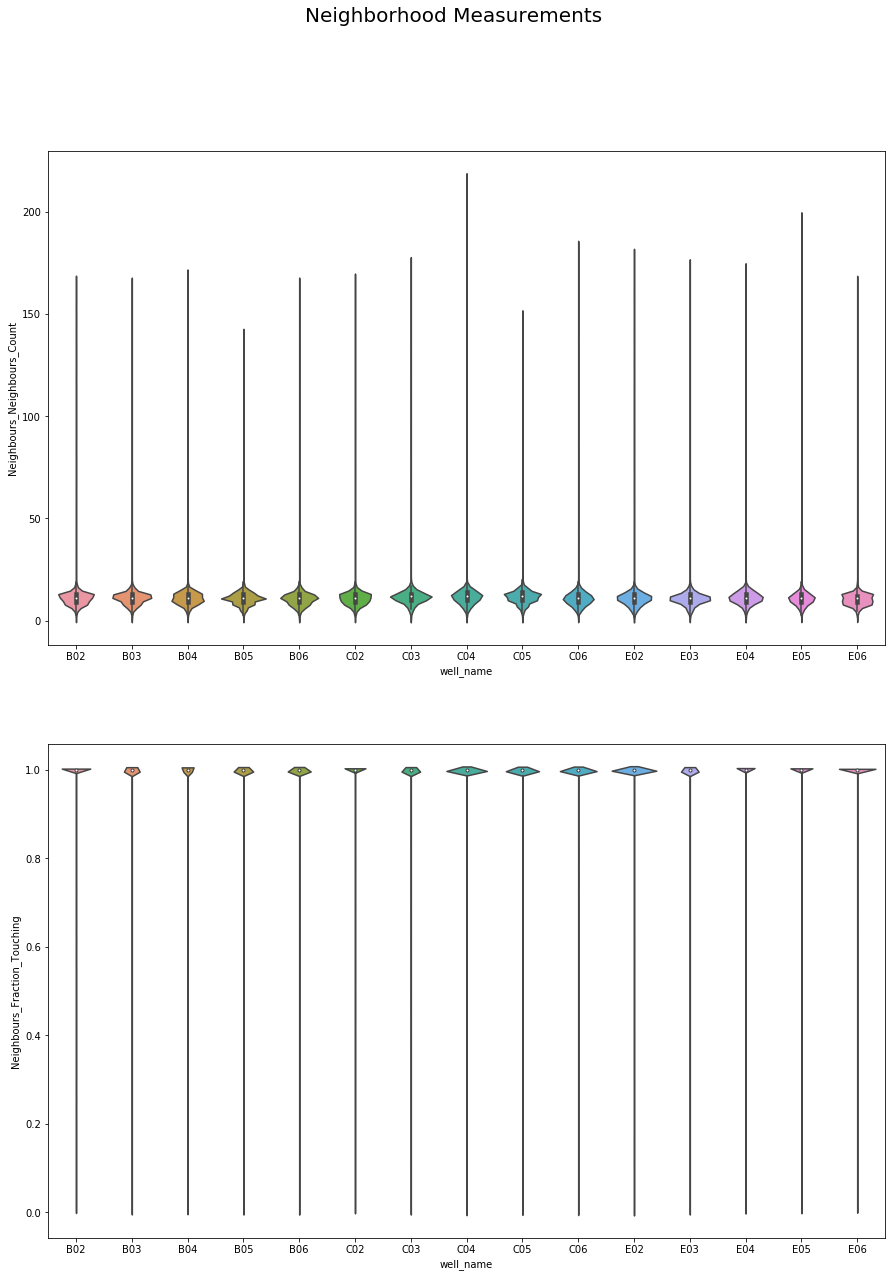

In [7]:
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Neighborhood Measurements', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'Neighbours_Neighbours_Count', data = results, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'Neighbours_Fraction_Touching', data = results, ax=ax1[1])

In [3]:
sum_intensity_dapi = 'Intensity_sum_dapi.rescaled_image'
sum_Intensity_568 = 'Intensity_sum_568.rescaled_image'
# Filter out cells that are thrown out by SVM
correct_segment = (results['Missegmented'] == 0)
non_mitotic = (results['Mitotic_Debris'] == 0)
non_border_cells = (results['is_border'] == 0)

# Filter out cells that have very low DAPI signal. Mostly missegmented HEK cells
normal_dapi = (results[sum_intensity_dapi] < 2500000) & (results[sum_intensity_dapi] > 500000)
# Filter out huge cells (missegmented cells)
normal_area = (results['Morphology_Area'] < 9000) & (results['Morphology_Area'] > 2000)
no_dapi_debris = results['Intensity_max_dapi.rescaled_image'] < 1200

# Remove cells with staining artefacts in 568 channel (no signal in B06 => don't exclude those)
no_568_artefact = ((results['Intensity_mean_568.rescaled_image'] > 100) & (results['Intensity_mean_568.rescaled_image'] < 1500)) | (results['well_name'] == 'E06')

# Remove all cells that are in a boundary site (e.g. don't have a 3x3 neighborhood => potentially biased distance to edge)
non_boundary_sites = (results['well_pos_y'] != 0) & (results['well_pos_y'] != 12) & (results['well_pos_x'] != 0) & (results['well_pos_x'] != 10)

# Misclassified edges: Some cells were classified as being very close to an edge because of a 
# segmentation error (very big cell clump not being separated). They are in a very dense region, but classified as edge. Throw them out.
no_edge_artefacts = ~((results['DistanceToEdge'] < 200) & (results['LocalDensity_Nuclei_500'] > 0.00045))



results_cleaned = results.loc[correct_segment & non_mitotic & non_border_cells & normal_dapi & normal_area & no_dapi_debris & no_568_artefact & non_boundary_sites & no_edge_artefacts]
# results_cleaned = results.loc[non_border_cells]
print('Filtered out {} cells, kept {} ({:.2f}%)'.format(results.shape[0] - results_cleaned.shape[0], results_cleaned.shape[0], results_cleaned.shape[0]/results.shape[0] *100))

results_cleaned['DAPI/568_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568]
results_cleaned['DAPI/568_sumIntensity [log2]'] = np.log2(results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568])


no_E06 = results_cleaned['well_name'] != 'E06'
results_cleaned_noE06 = results_cleaned.loc[no_E06]

Filtered out 789922 cells, kept 390103 (33.06%)


/Users/Joel/.virtualenvs/hiPSC/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Joel/.virtualenvs/hiPSC/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
print(sum(non_border_cells))
print(sum(correct_segment))
print(sum(non_mitotic))
print(sum(normal_dapi))
print(sum(no_568_artefact))
print(sum(no_edge_artefacts))

edge_disagreements = (results_cleaned['DistanceToEdge'] < 100) & (results_cleaned['LocalDensity_Nuclei_500'] > 0.00045)
print(results_cleaned.loc[edge_disagreements])


1050057
750410
898617
1051745
1028599
1105097
Empty DataFrame
Columns: [mapobject_id, Morphology_Local_Centroid_x, Morphology_Local_Centroid_y, Morphology_Area, Morphology_Perimeter, Morphology_Eccentricity, Morphology_Extent, Morphology_Convexity, Morphology_Circularity, Morphology_Roundness, Morphology_Elongation, Morphology_Equivalent_Diameter, Morphology_Major_Axis_Length, Morphology_Minor_Axis_Length, Morphology_Maximum_Radius, Morphology_Mean_Radius, Intensity_max_dapi.rescaled_image, Intensity_mean_dapi.rescaled_image, Intensity_min_dapi.rescaled_image, Intensity_sum_dapi.rescaled_image, Intensity_std_dapi.rescaled_image, Intensity_max_647.rescaled_image, Intensity_mean_647.rescaled_image, Intensity_min_647.rescaled_image, Intensity_sum_647.rescaled_image, Intensity_std_647.rescaled_image, Intensity_max_568.rescaled_image, Intensity_mean_568.rescaled_image, Intensity_min_568.rescaled_image, Intensity_sum_568.rescaled_image, Intensity_std_568.rescaled_image, Neighbours_Neighbours

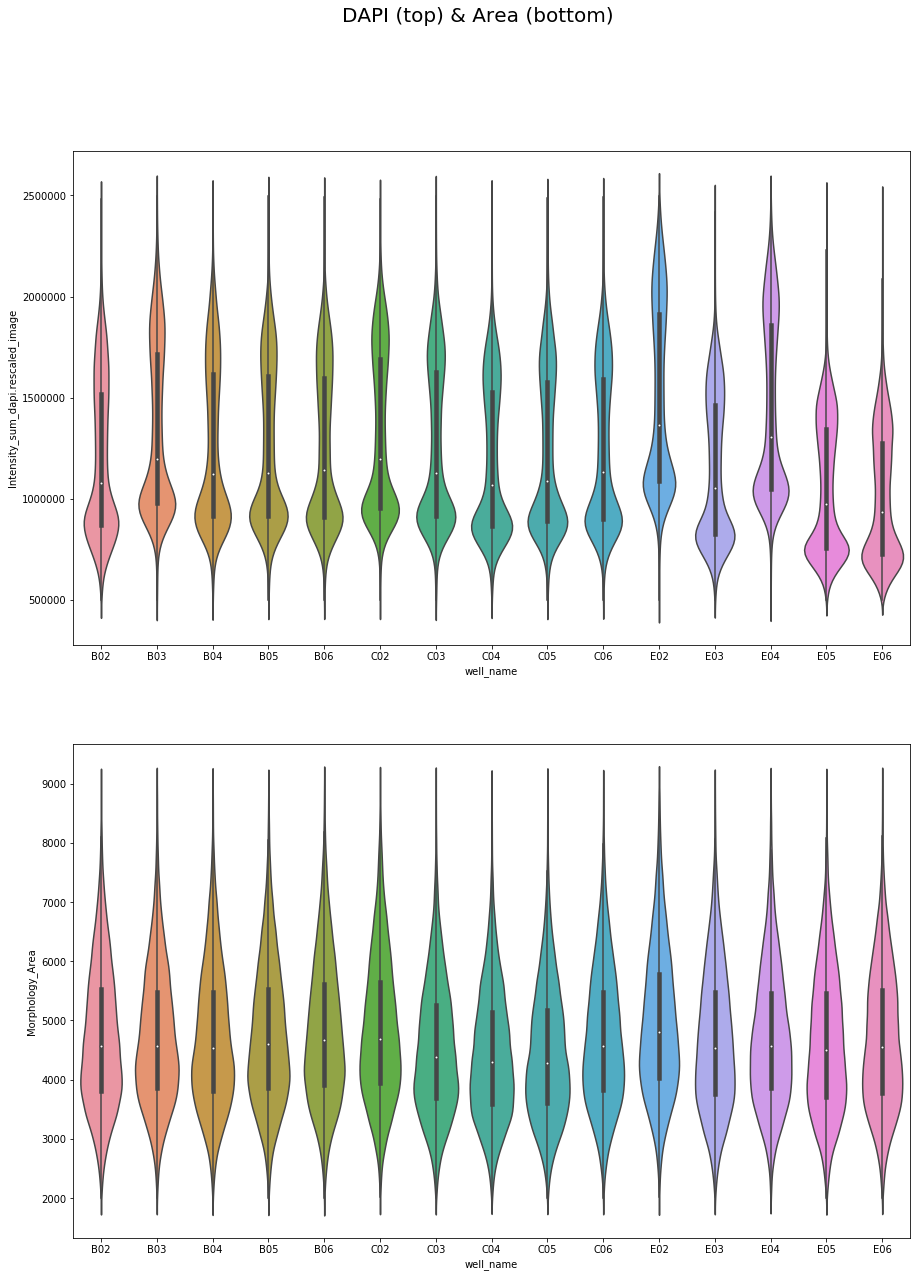

In [68]:
# Make some quality control plots
# DAPI violin plots
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('DAPI (top) & Area (bottom)', fontsize = 20)
sns.violinplot(x = 'well_name', y = sum_intensity_dapi, data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'Morphology_Area', data = results_cleaned, ax=ax1[1])

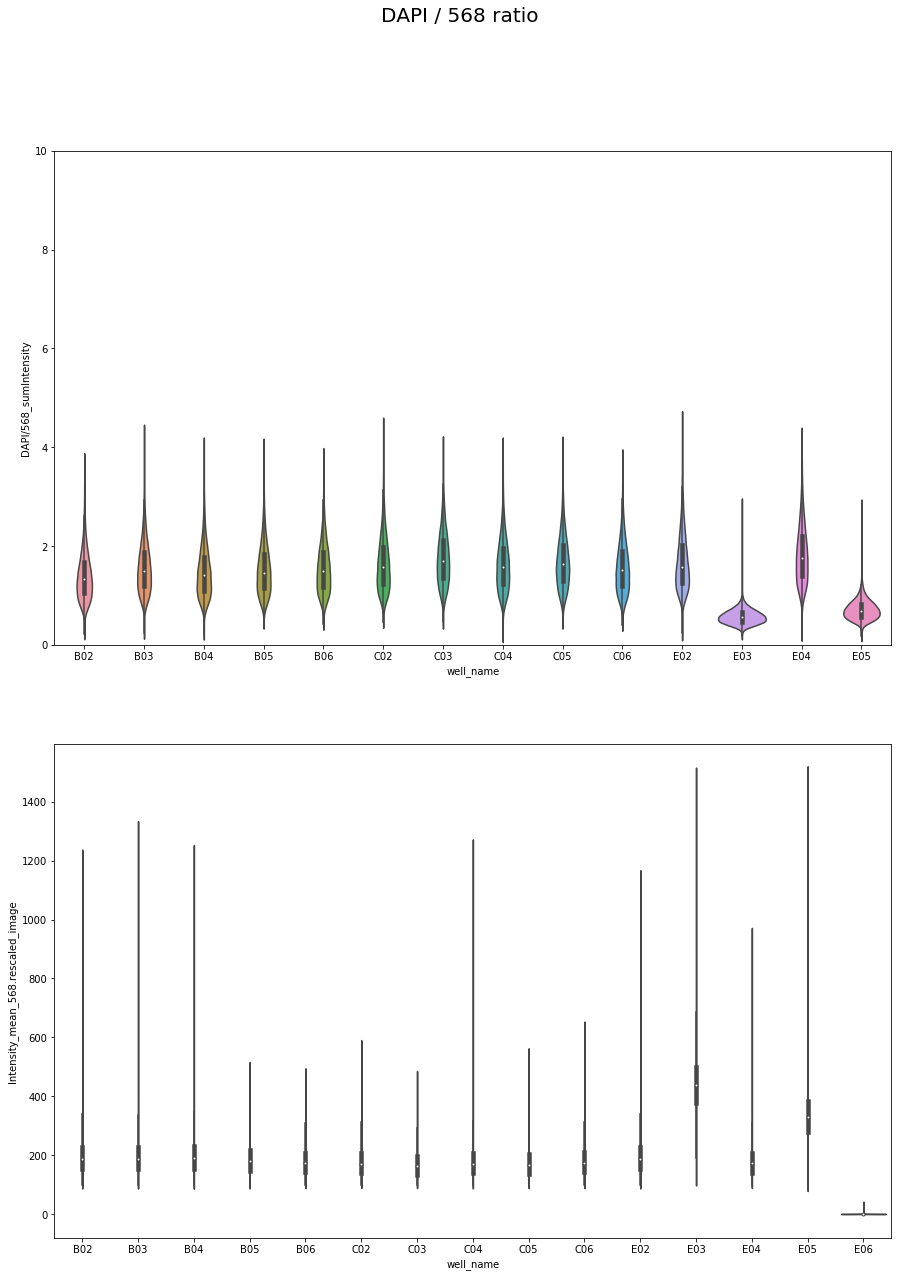

In [70]:
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('DAPI / 568 ratio', fontsize = 20)
lm = sns.violinplot(x = 'well_name', y = 'DAPI/568_sumIntensity', ylim=(0,10), data = results_cleaned_noE06, ax=ax1[0])
axes = lm.axes
axes.set_ylim(0,10)
lm2 =sns.violinplot(x = 'well_name', y = 'Intensity_mean_568.rescaled_image', data = results_cleaned, ax=ax1[1])
# axes = lm2.axes
# axes.set_ylim(0,200)
# well_name = 'B03'
# curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
# g = sns.jointplot(x = 'Intensity_max_dapi.rescaled_image', y = 'DAPI/568_sumIntensity', data = curr_well, s=5) #, kind ='kde'

# print(curr_well.loc[curr_well['DAPI/568_sumIntensity'] > 80])


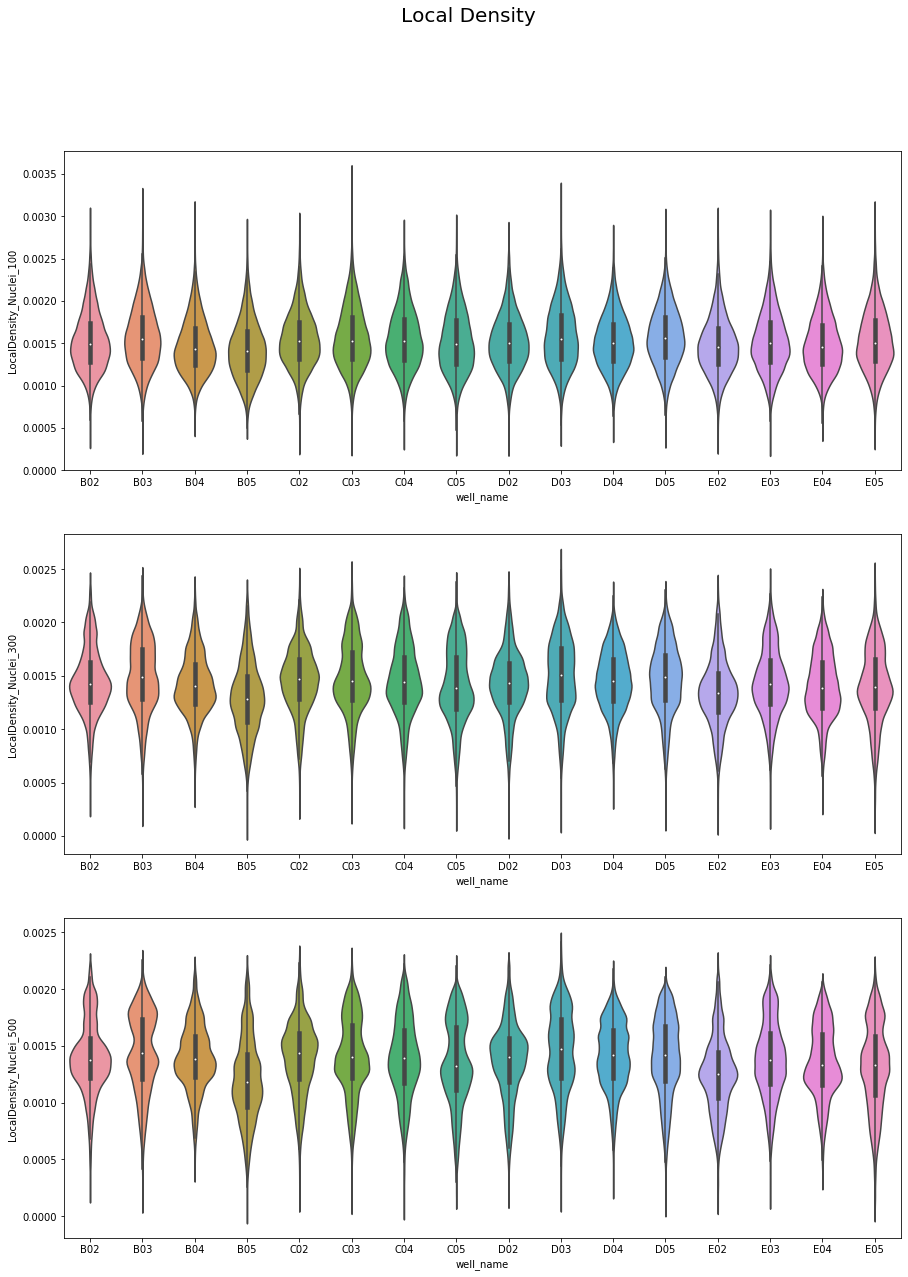

In [123]:
# Plot local density measurements
fig1, ax1 = plt.subplots(3, 1, figsize=(15, 20))
fig1.suptitle('Local Density', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_100', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_300', data = results_cleaned, ax=ax1[1])
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_500', data = results_cleaned, ax=ax1[2])

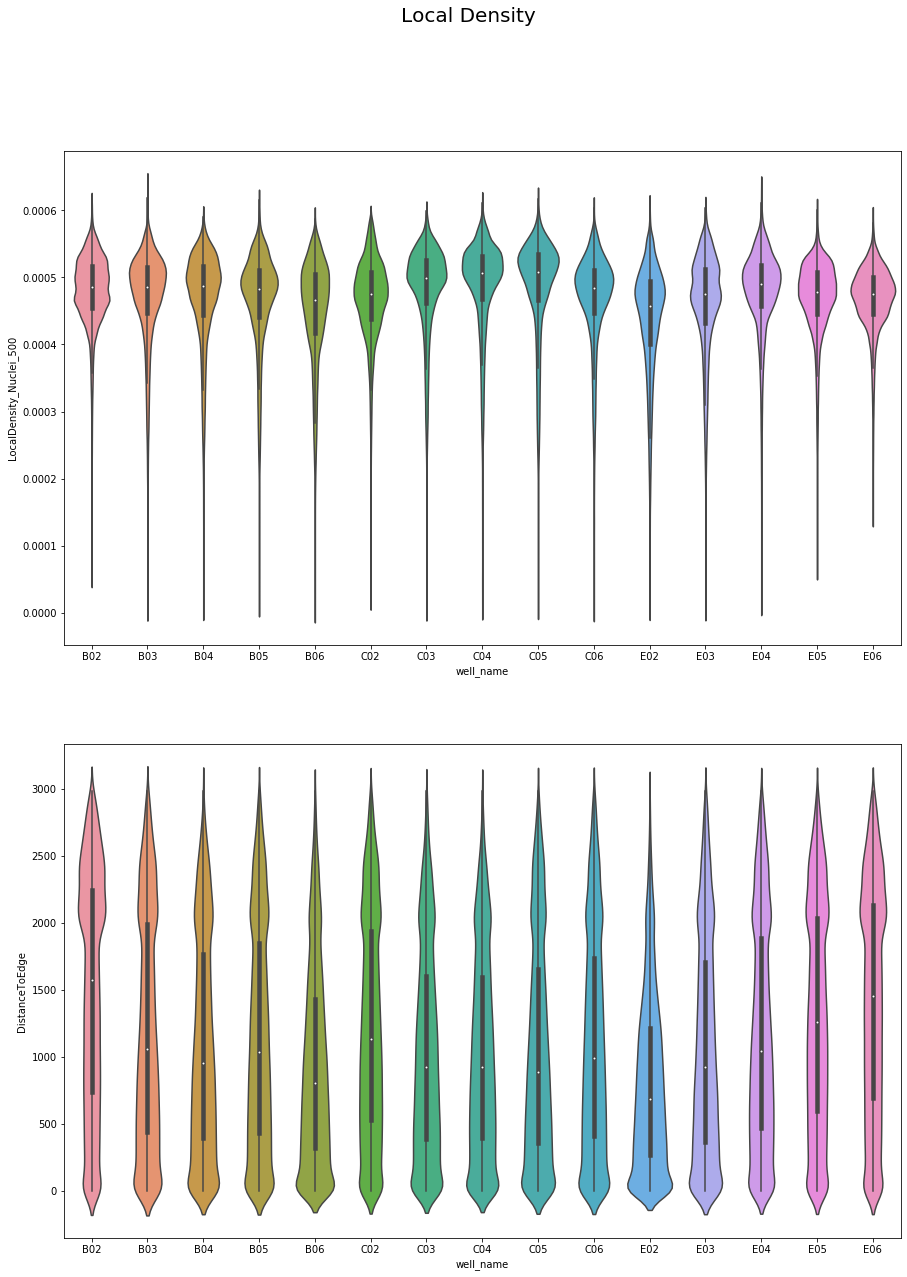

In [17]:
# Plot local density measurements
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Local Density', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_500', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'DistanceToEdge', data = results_cleaned, ax=ax1[1])

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


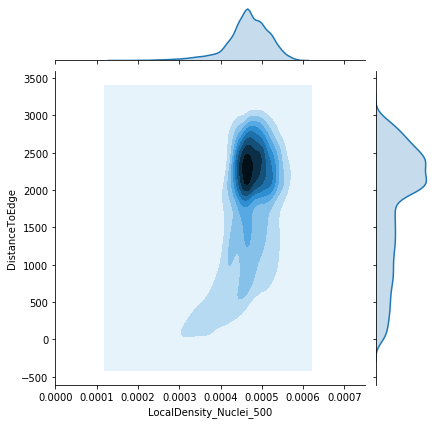

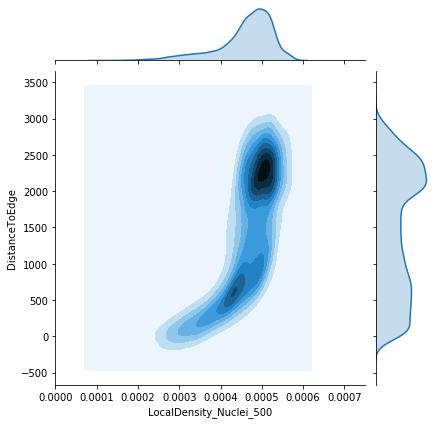

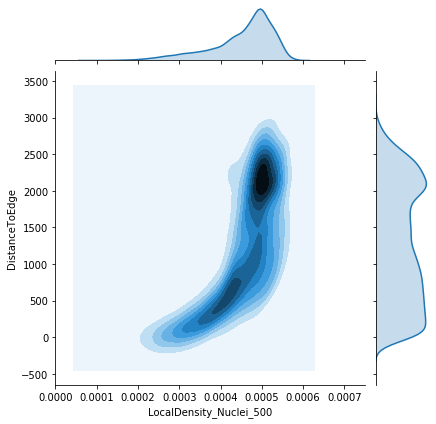

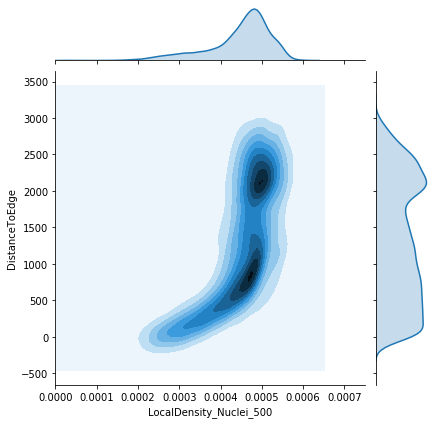

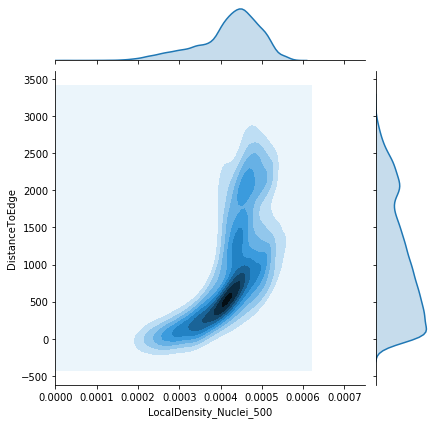

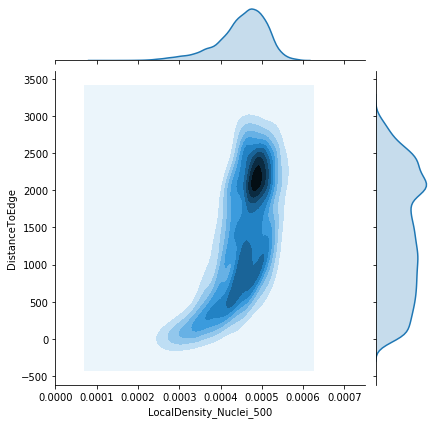

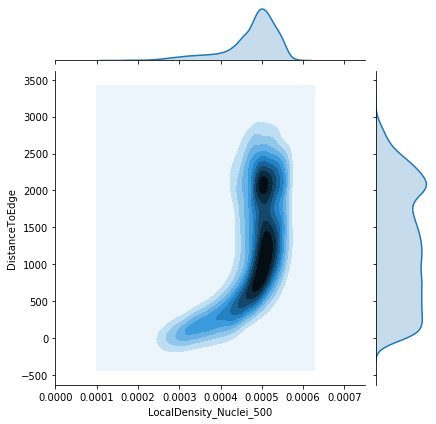

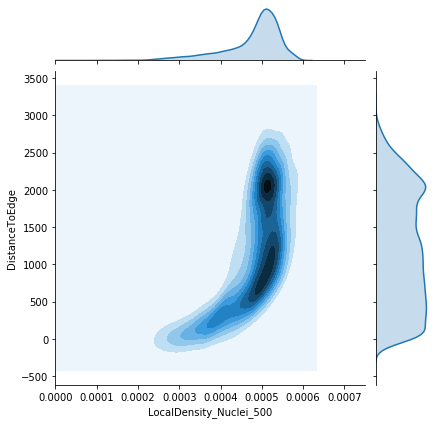

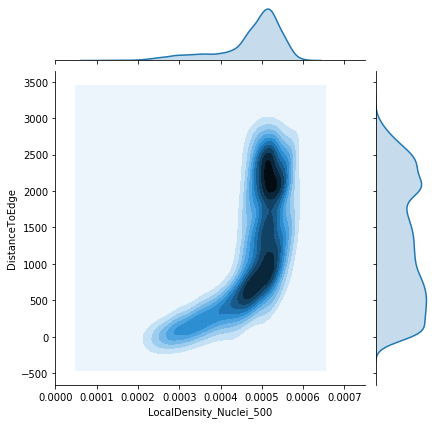

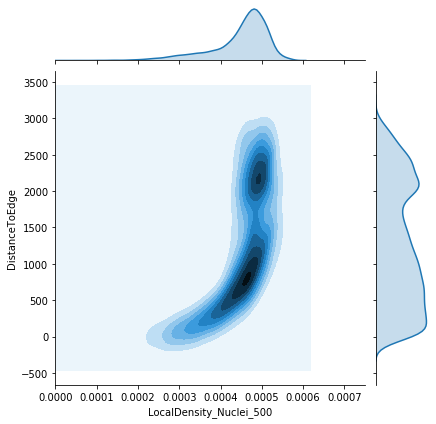

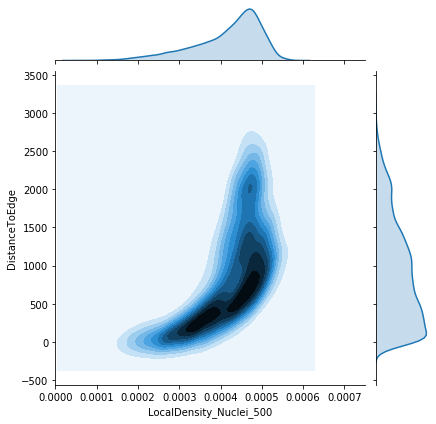

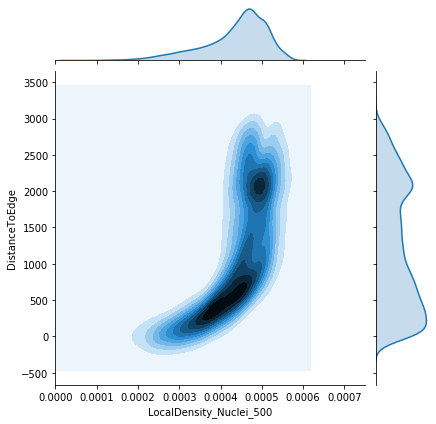

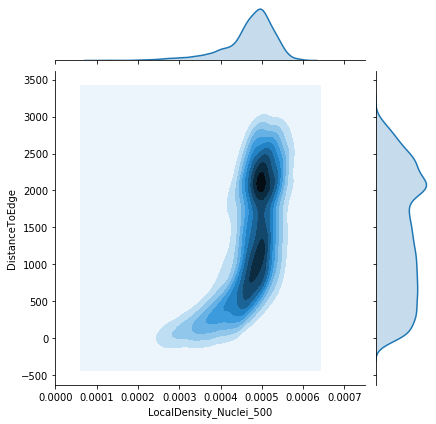

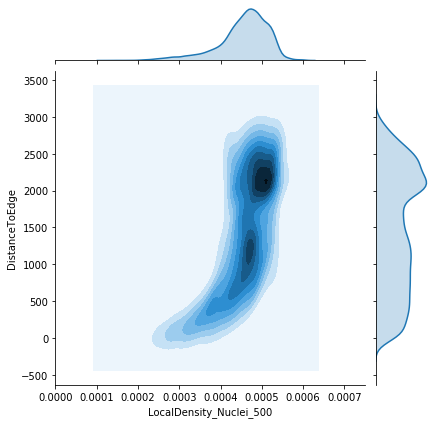

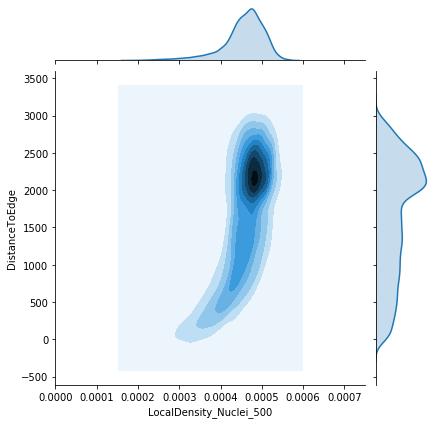

In [22]:
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DistanceToEdge', data = curr_well, s=5, xlim=(0, 0.00075), kind ='kde')
    g.savefig(well_name + '_DensityVsEdge_Cleaned.png')

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


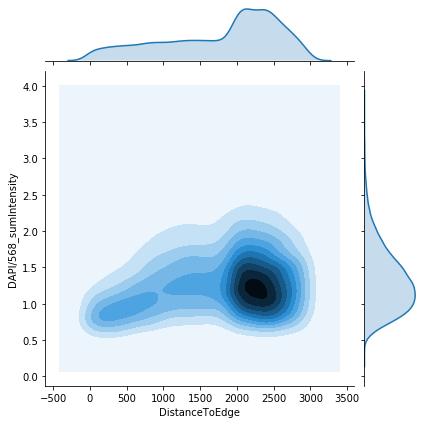

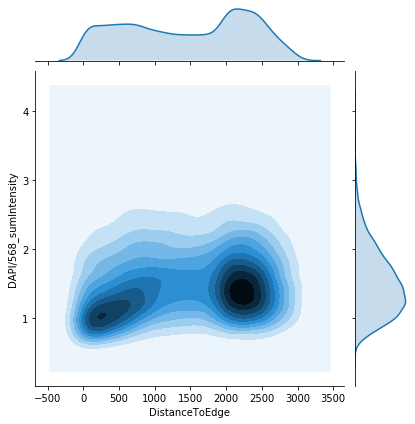

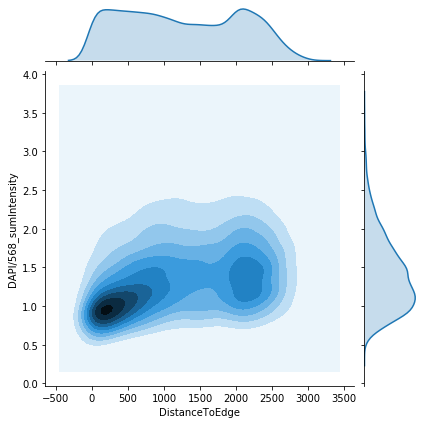

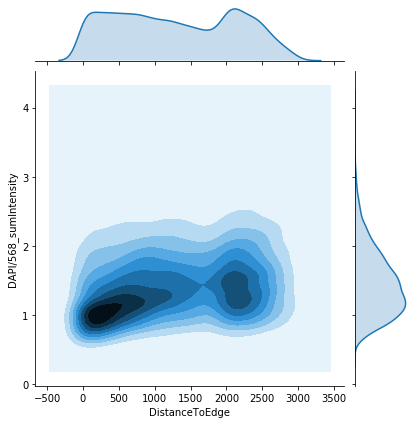

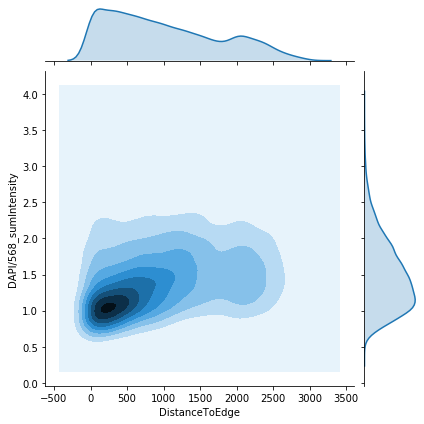

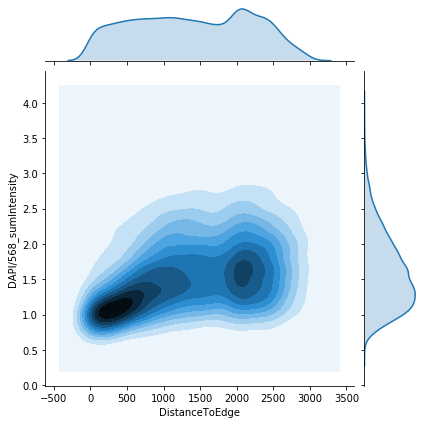

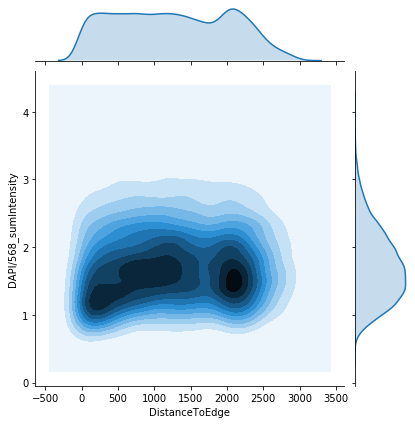

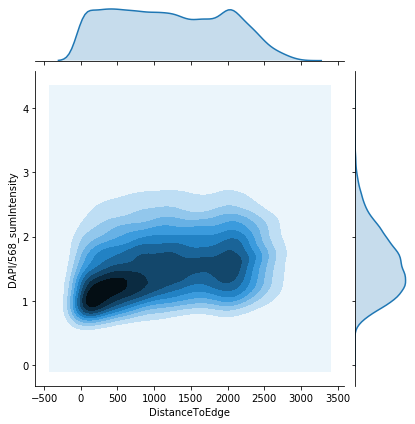

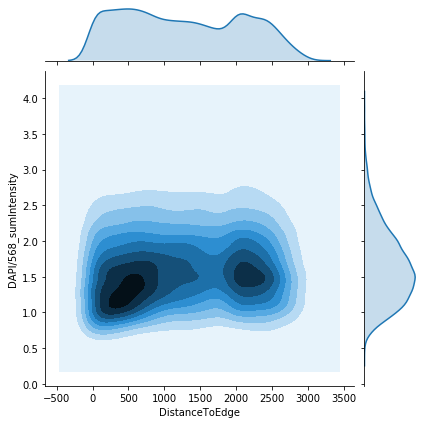

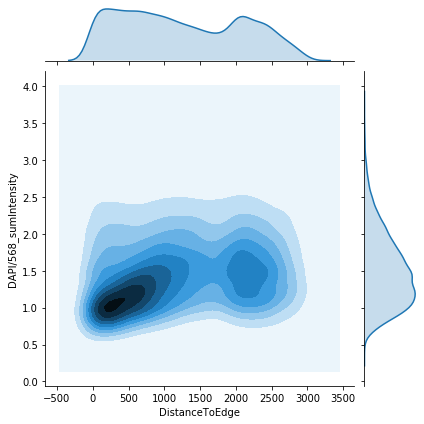

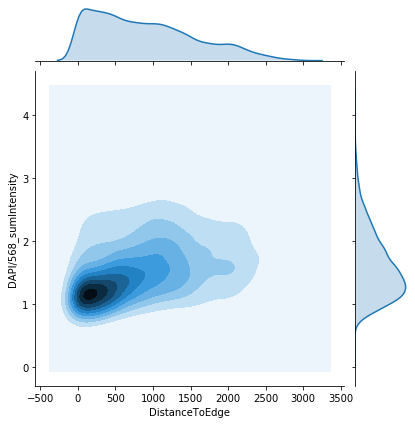

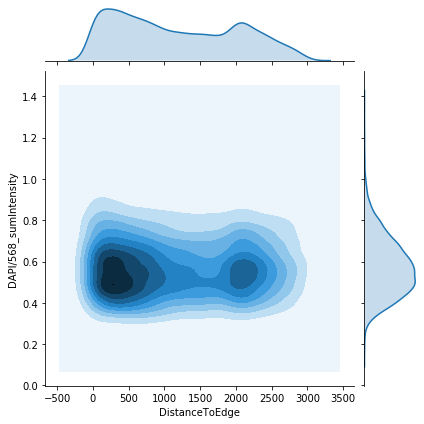

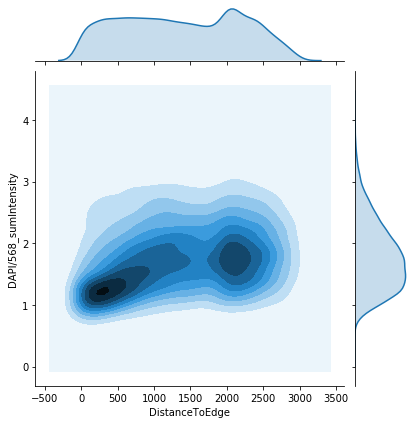

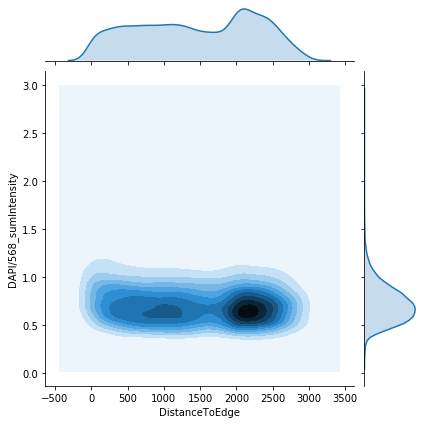

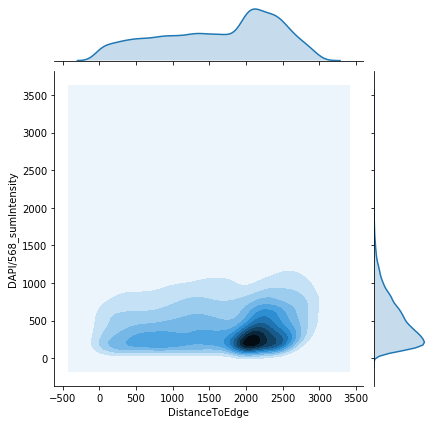

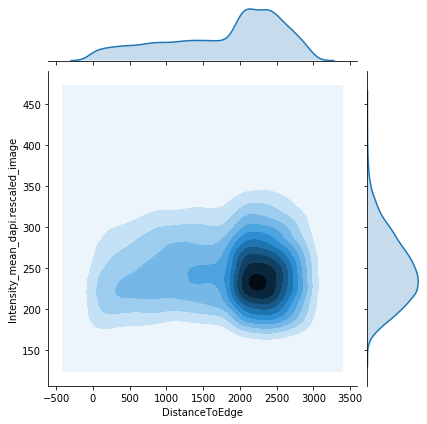

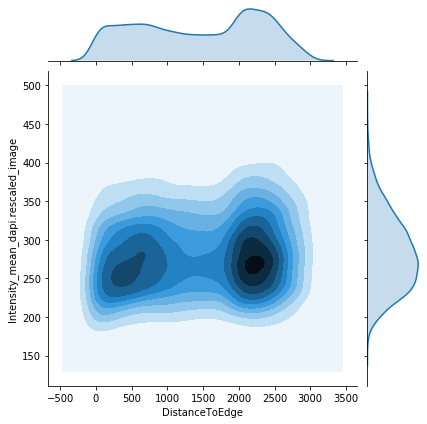

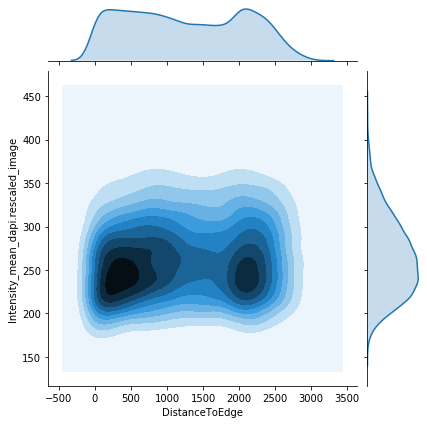

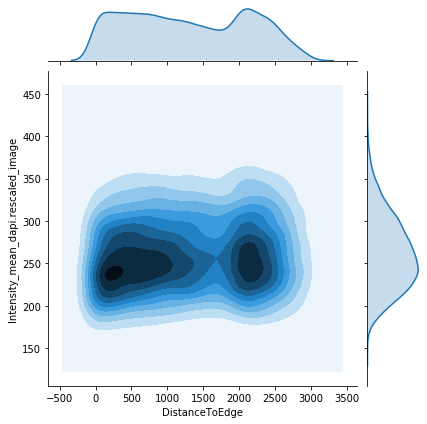

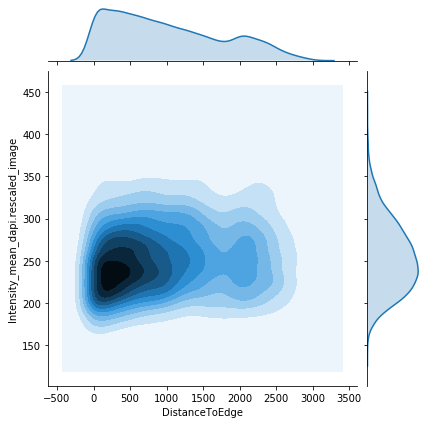

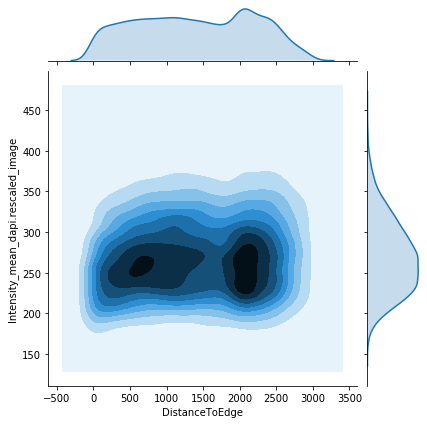

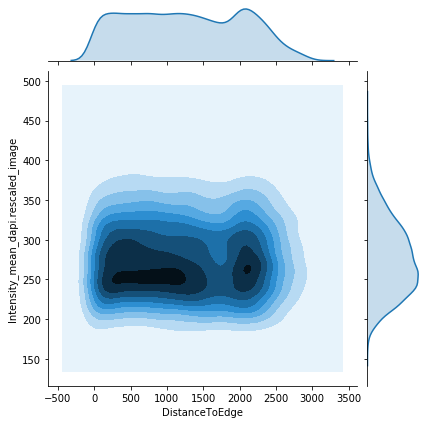

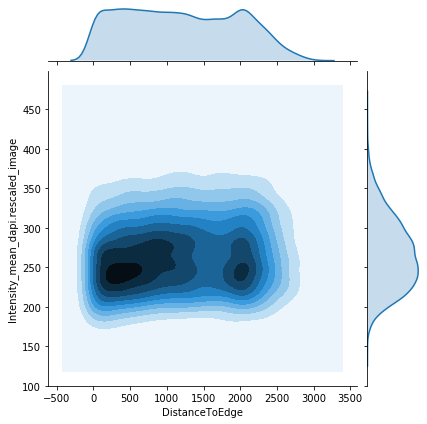

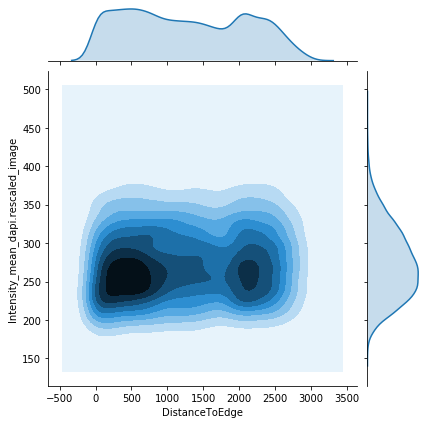

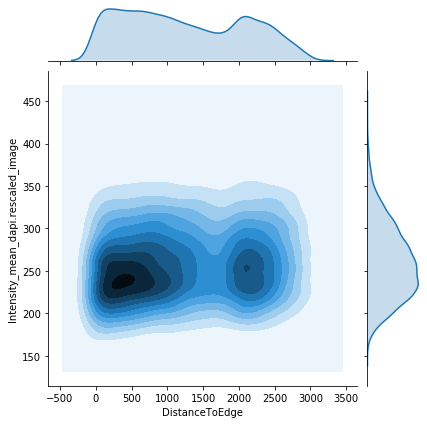

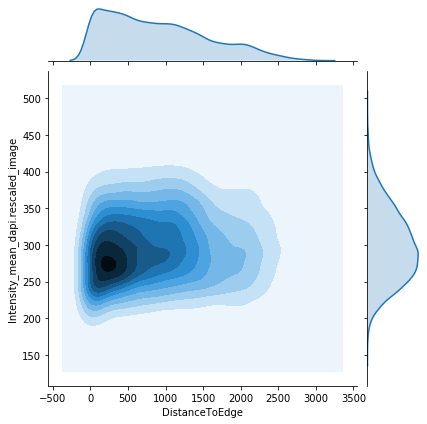

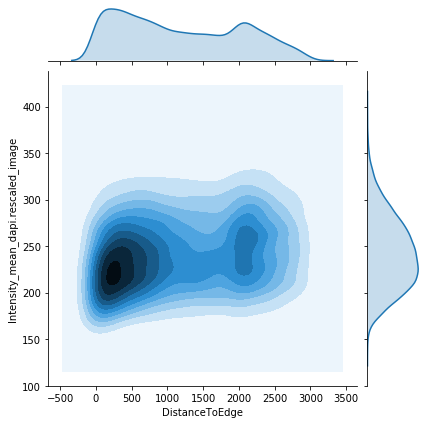

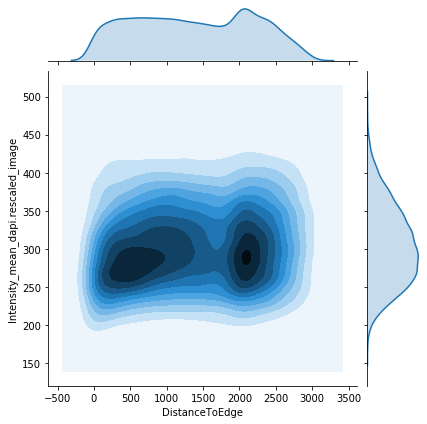

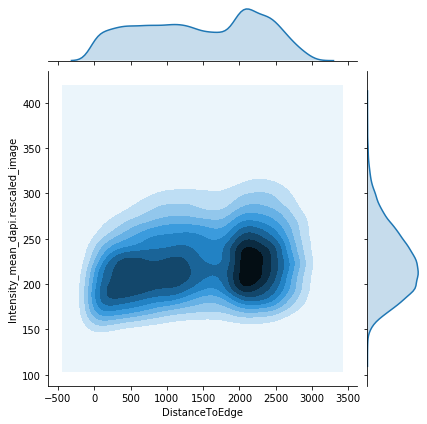

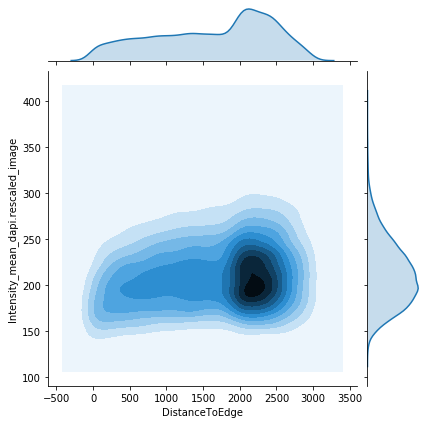

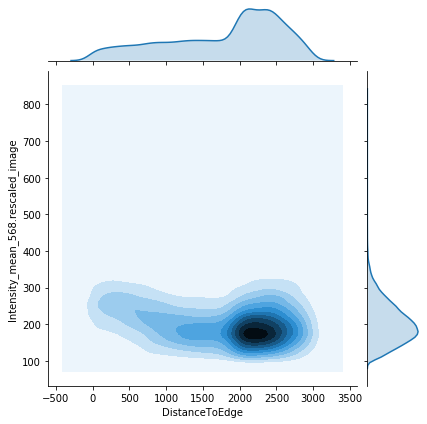

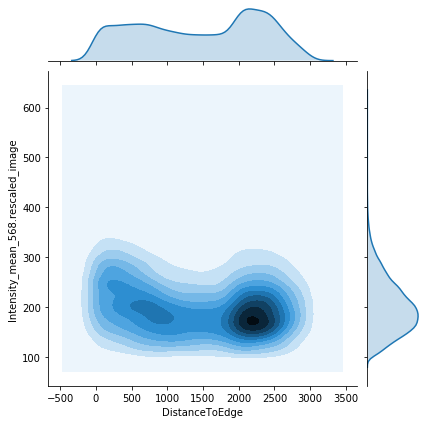

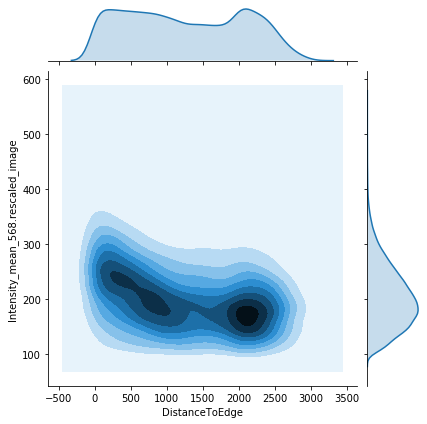

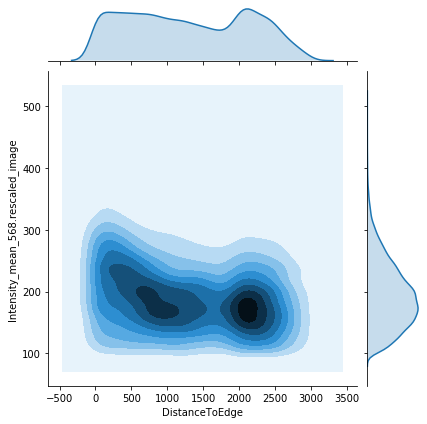

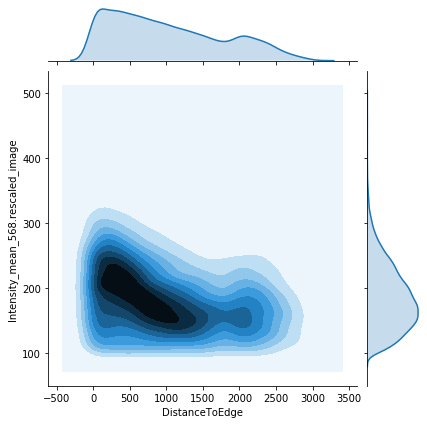

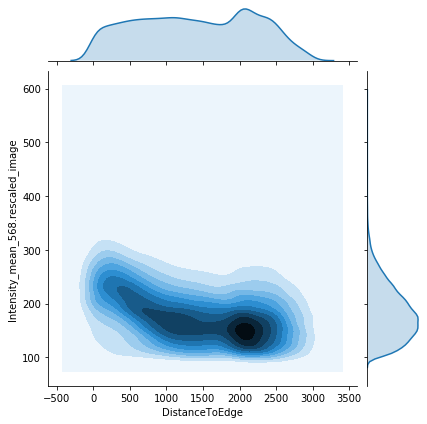

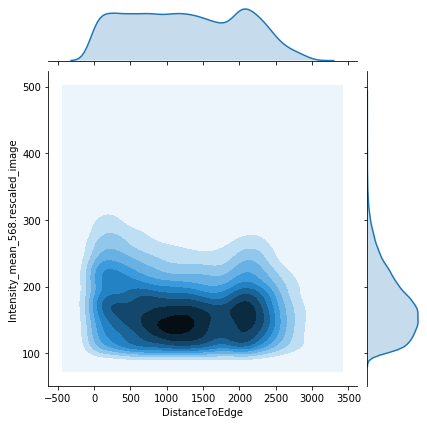

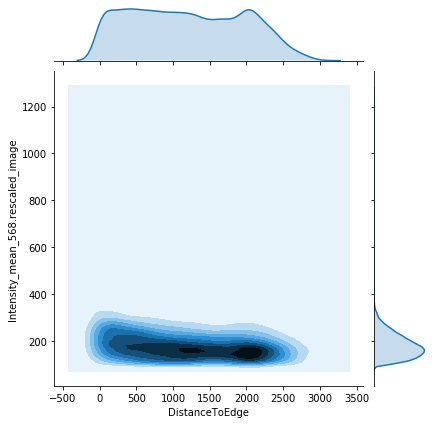

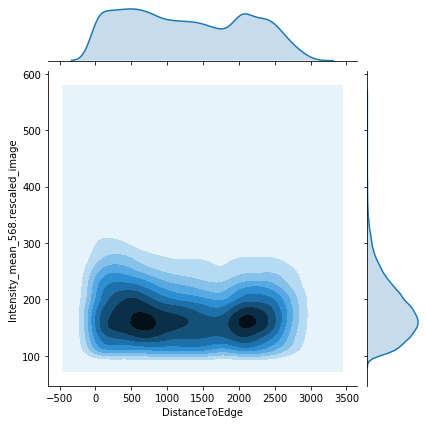

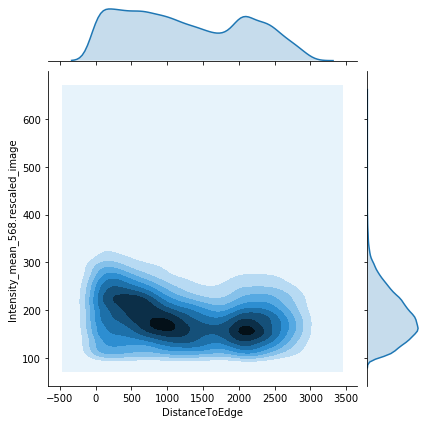

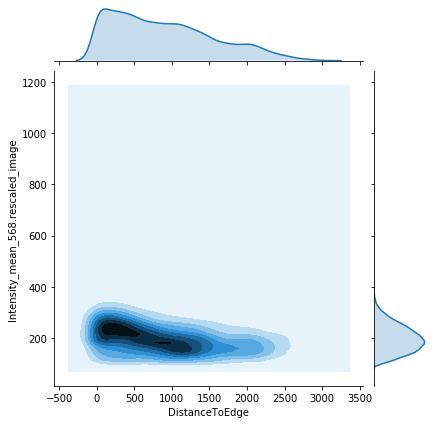

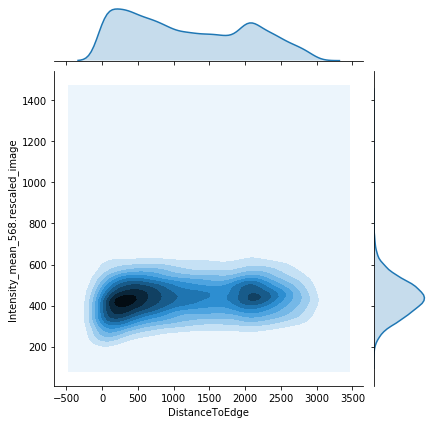

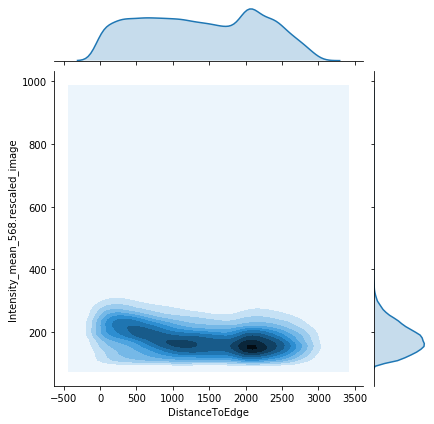

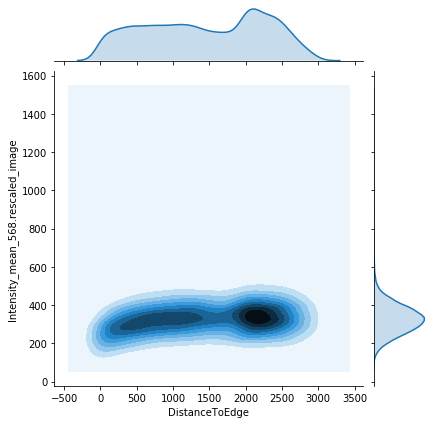

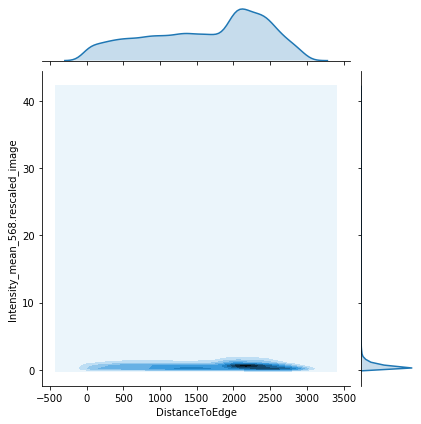

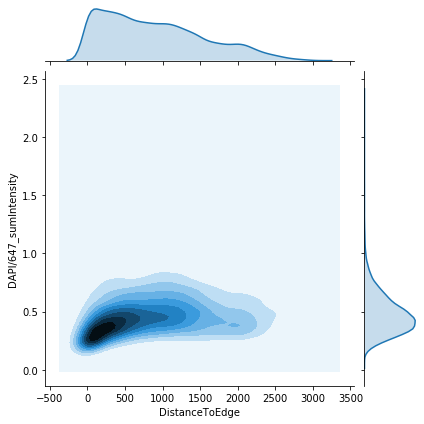

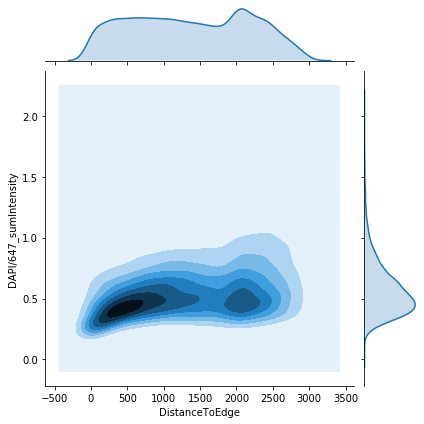

In [23]:
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/568_sumIntensity', data = curr_well, s=5, kind ='kde')
    g.savefig(well_name + '_EdgeVsDapiToNanog.png')
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_dapi.rescaled_image', data = curr_well, s=5, kind ='kde')
    g.savefig('EdgeVsDapi_' + well_name + '.png')

for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_568.rescaled_image', data = curr_well, s=5, kind ='kde')
    g.savefig('EdgeVs568_' + well_name + '.png')

results_cleaned['DAPI/647_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned['Intensity_sum_647.rescaled_image']
wells_tmp = ['E02', 'E04']
for well_name in wells_tmp:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/647_sumIntensity', data = curr_well, kind ='kde')
    g.savefig('EdgeVs647_' + well_name + '.png')
    

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


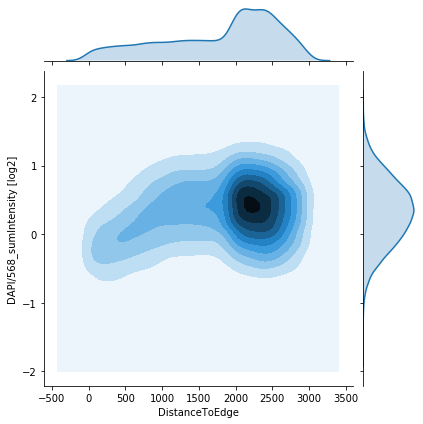

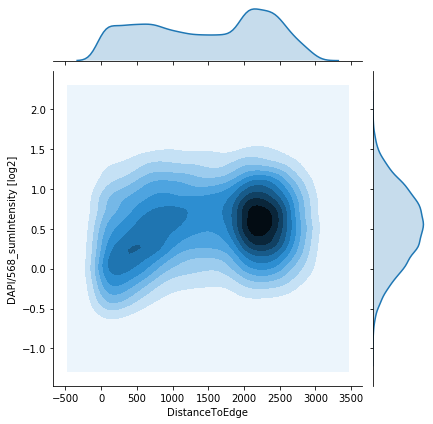

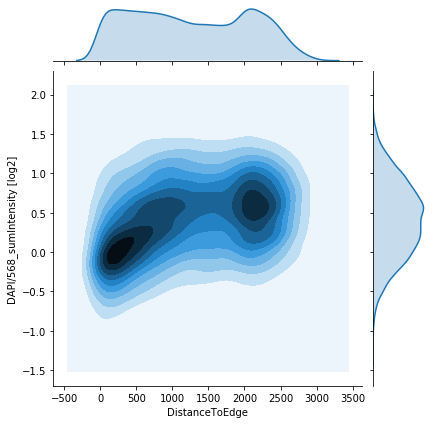

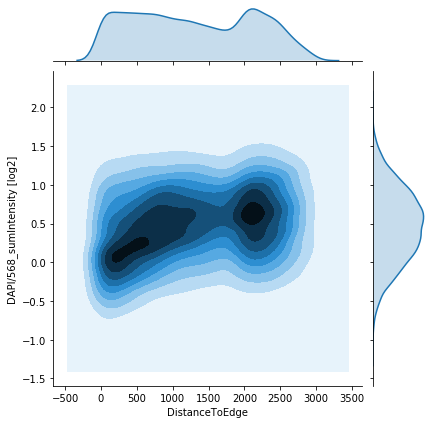

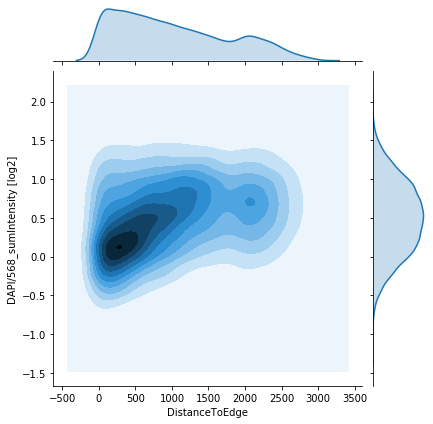

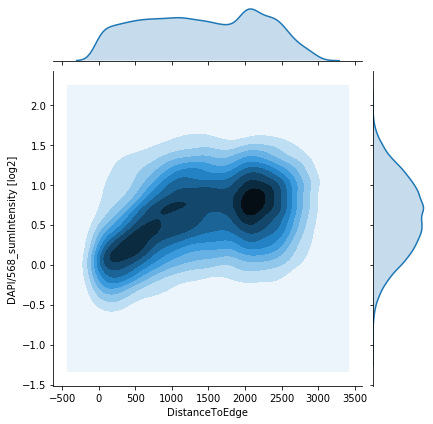

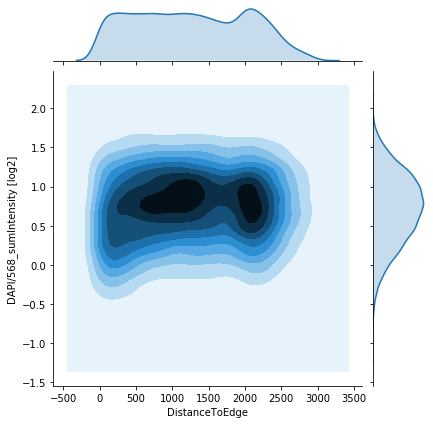

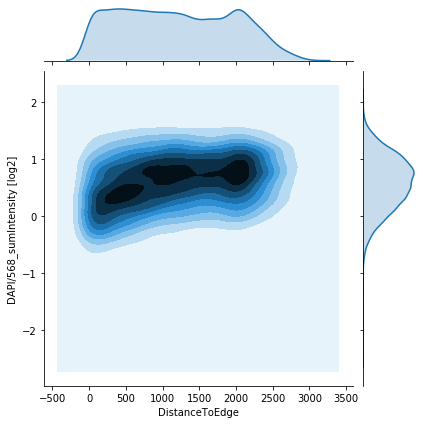

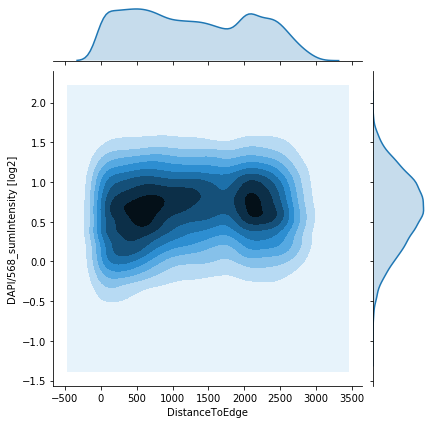

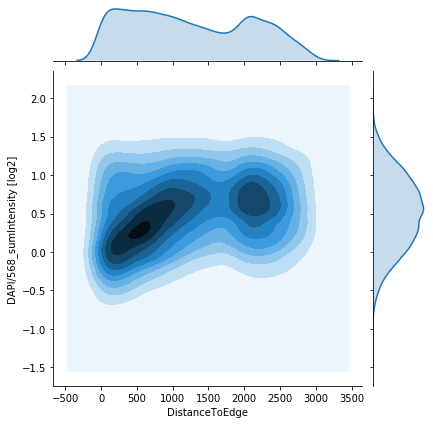

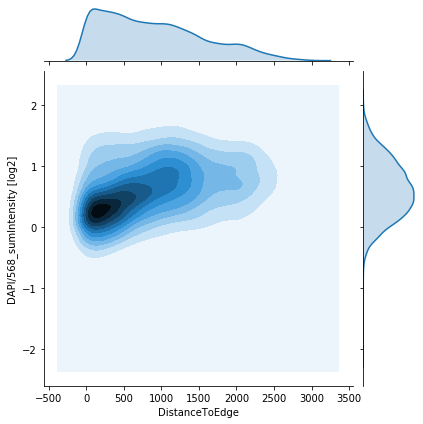

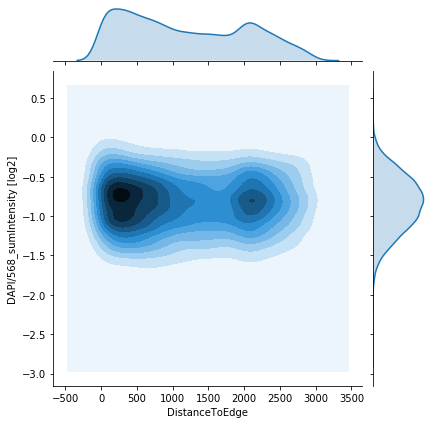

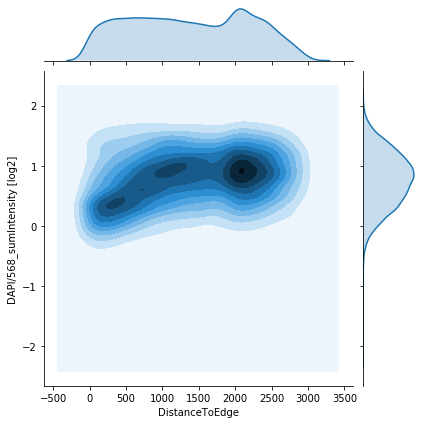

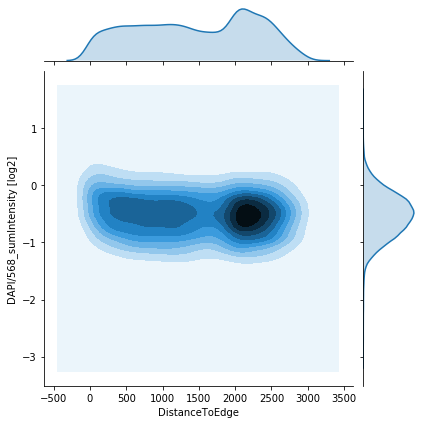

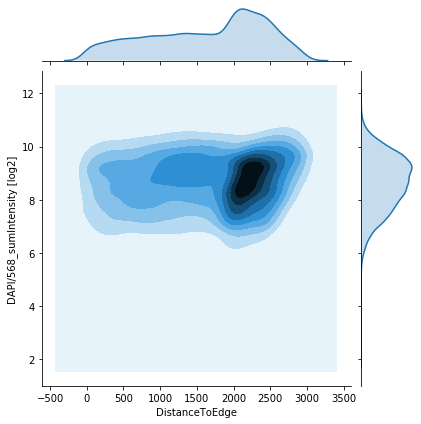

In [24]:
results_cleaned['DAPI/568_sumIntensity [log2]'] = np.log2(results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568])

for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/568_sumIntensity [log2]', data = curr_well, s=5, kind ='kde')
    g.savefig(well_name + '_EdgeVsDapiToNanog.png')
    
# for well_name in wells:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_dapi.rescaled_image', data = curr_well, s=5, kind ='kde')
#     g.savefig('EdgeVsDapi_' + well_name + '.png')

# for well_name in wells:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_568.rescaled_image', data = curr_well, s=5, kind ='kde')
#     g.savefig('EdgeVs568_' + well_name + '.png')

# results_cleaned['DAPI/647_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned['Intensity_sum_647.rescaled_image']
# wells_tmp = ['E02', 'E04']
# for well_name in wells_tmp:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/647_sumIntensity', data = curr_well, kind ='kde')
#     g.savefig('EdgeVs647_' + well_name + '.png')

0.1366030800696677
0.20921605042739236
0.10388311647366699
0.2601928218150626
0.20380889862385385
0.20163097747858627
0.21433978869323864
0.23115329799401324
0.14935220022601003
0.1313155693243598
0.14012979859218827
0.16847847259633583
0.16205954135313955
0.15882245340014342
0.16292429799343555
0.18295784001295404


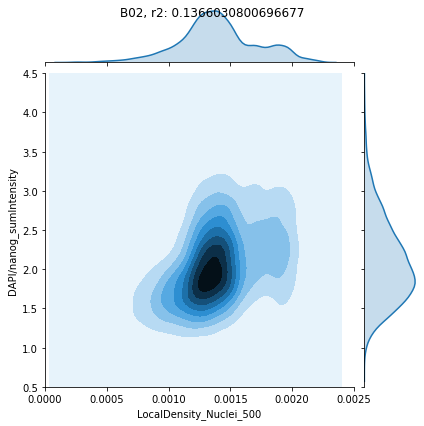

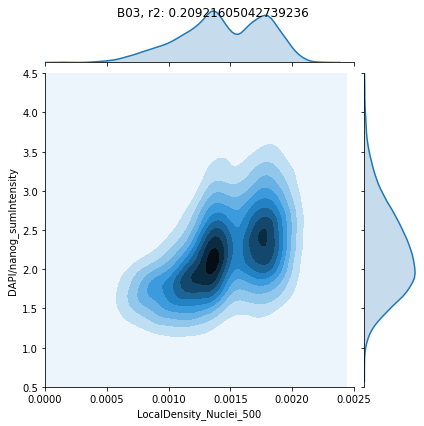

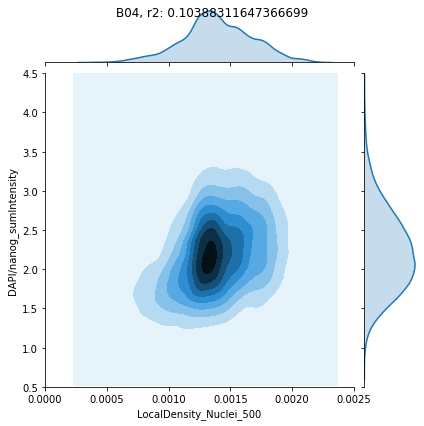

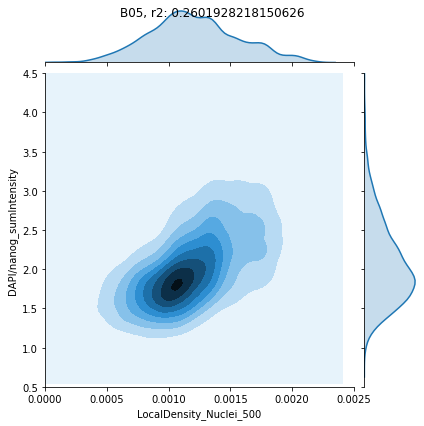

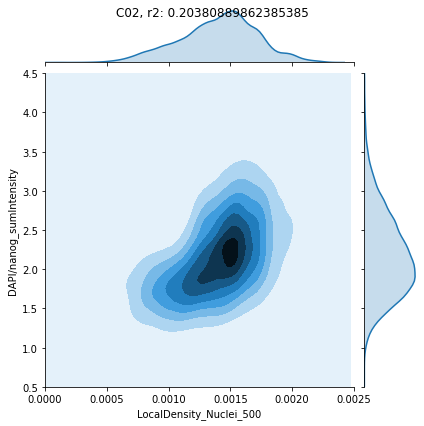

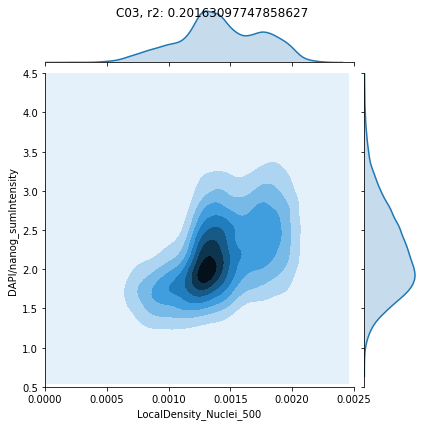

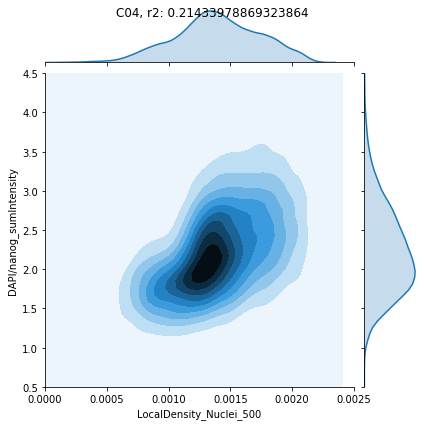

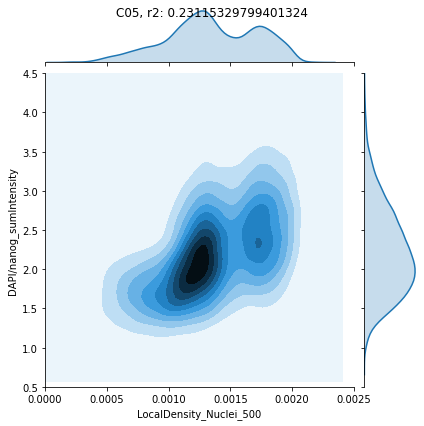

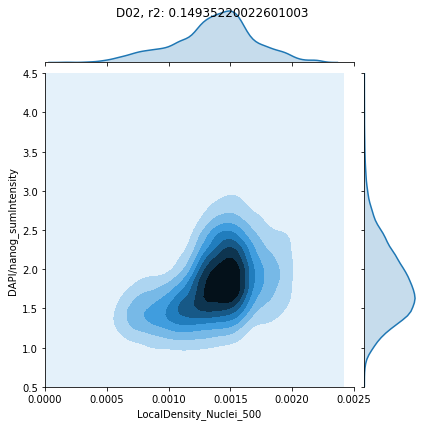

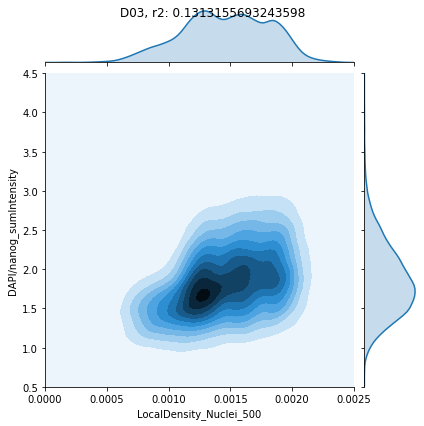

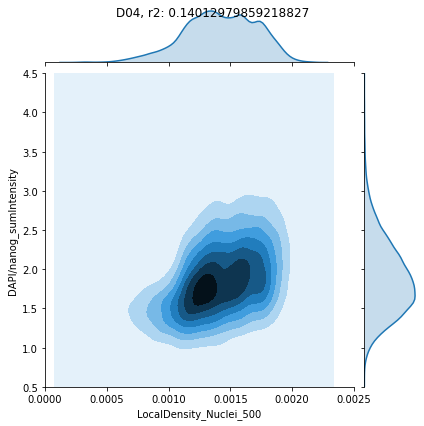

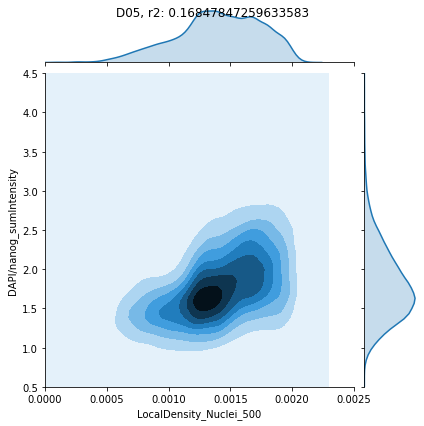

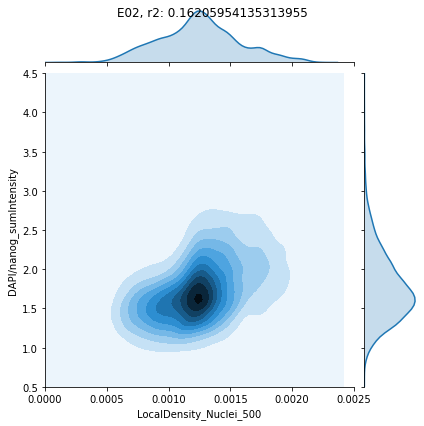

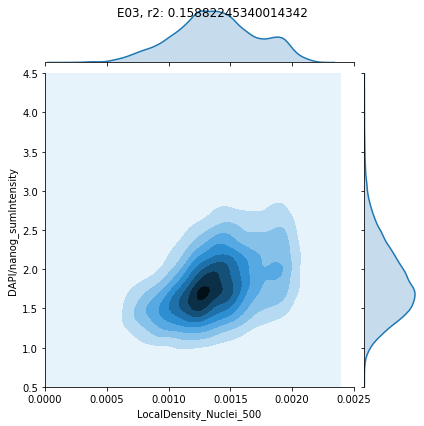

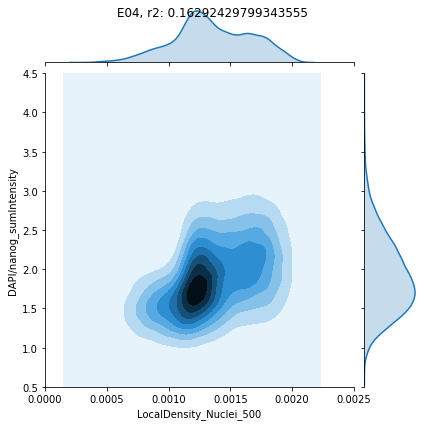

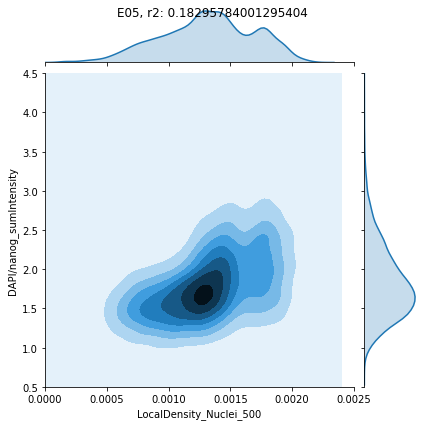

In [122]:
# Plot relationship DAPI/nanog (vs. density)
import scipy
# well_name = 'B04'
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

    # fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
    # fig1.suptitle('DAPI/nanog Intensity Ratio', fontsize = 20)
    # sns.violinplot(x = 'well_name', y = 'DAPI/nanog_sumIntensity', data = results_cleaned, ax=ax1[0])

    # g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5)) # 
    g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5), kind ='kde')

    # Calculate correlation between Density & DAPI/nanog
    density = np.array(curr_well['LocalDensity_Nuclei_500'])
    intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
    print(r_value*r_value)


    g.fig.suptitle(well_name + ', r2: ' + str(r_value*r_value))

    g.savefig(well_name + '_DensityVsStainingBias.png')


In [116]:
# Calculate correlation between Density & DAPI/nanog
import scipy
well_name = 'B02'
curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

density = np.array(curr_well['LocalDensity_Nuclei_500'])
intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
print(r_value*r_value)



0.1366030800696677


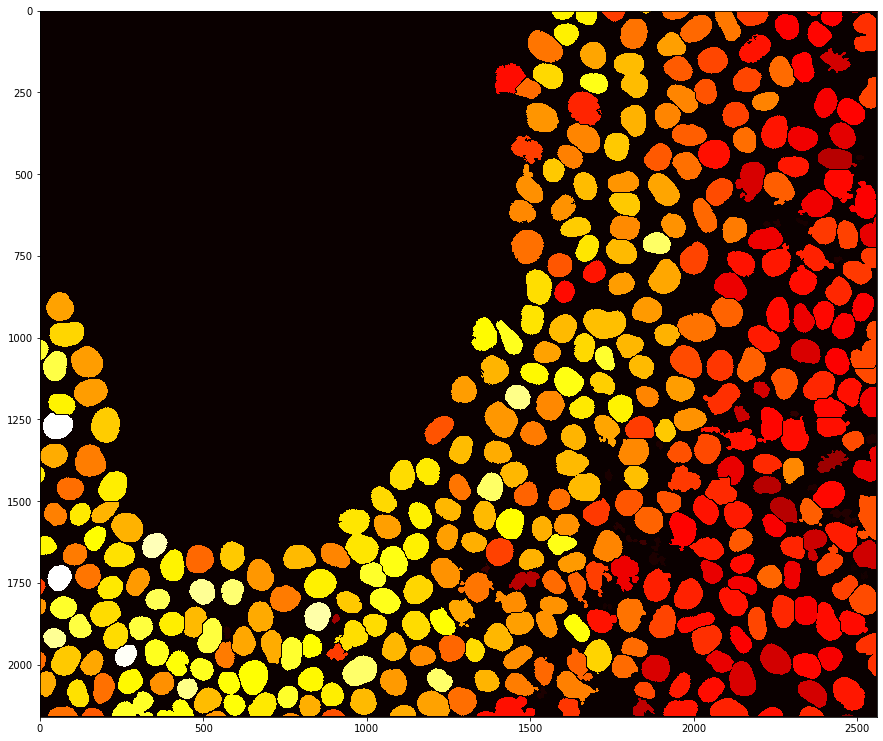

In [7]:
# Local density mapped back on the images
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Define site of interest
well_name = 'B02'
well_pos_y = 7
well_pos_x = 8
current_site_bool = (results['well_name'] == well_name) & (results['well_pos_y'] == well_pos_y)  & (results['well_pos_x'] == well_pos_x)

current_site = results.loc[current_site_bool]

# Get the segmentation mask from TissueMaps
import tmclient
host="172.23.178.177"
port = 80
experimentName="20190702-StainingTest1"
username="jluethi"
password="Cora-Cardiff-emergent-glitzy"
mapobject="Nuclei"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

segmentation_image = client.download_segmentation_image(mapobject, plate_name, well_name, well_pos_y, well_pos_x)
# plt.figure(figsize=(15,20))
# imgplot = plt.imshow(segmentation_image)

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['Intensity_mean_568.rescaled_image']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img, cmap='hot')


In [32]:
# Stitch multiple sites for population overview

# Get the segmentation mask from TissueMaps
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190702-StainingTest1"
username="joel"
password="123456"
mapobject="Nuclei"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']


start_site_y = 6
start_site_x = 5
# start_site_y = 9
# start_site_x = 7

img_width = 2560
img_height = 2160

nb_sites_y = 4
nb_sites_x = 4
all_sites = np.zeros((2160*nb_sites_y, 2560*nb_sites_x))
well_name = 'B02'
feature_of_interest = 'Intensity_mean_568.rescaled_image'

for site_x in range(nb_sites_x):
    for site_y in range(nb_sites_y):
        # Reinitialize the client every round, otherwise it seems to run into timeouts and produces 502 errors.
        client = tmclient.TmClient(host, port, username, password, experimentName)
        print(start_site_y + site_y, start_site_x + site_x)
        # Define site of interest
        well_pos_y = start_site_y + site_y
        well_pos_x = start_site_x + site_x
        current_site_bool = (results['well_name'] == well_name) & (results['well_pos_y'] == well_pos_y)  & (results['well_pos_x'] == well_pos_x)
        current_site = results.loc[current_site_bool]
        
        segmentation_image = client.download_segmentation_image(mapobject, plate_name, well_name, well_pos_y, well_pos_x)
        labels = current_site['label']

        for label in labels:
            current_cell = current_site.loc[current_site['label'] == label]
            all_sites[site_y*img_height:(site_y+1)*img_height, site_x*img_width:(site_x+1)*img_width][segmentation_image == label] = current_cell[feature_of_interest]




6 5
7 5
8 5
9 5
6 6
7 6
8 6
9 6
6 7
7 7
8 7
9 7
6 8
7 8
8 8
9 8


In [35]:
plt.figure(figsize=(15,20))
# imgplot = plt.imshow(all_sites, cmap='hot')
plt.imsave('/Users/Joel/Desktop/Overview_img.png', all_sites, cmap='hot')

<Figure size 1080x1440 with 0 Axes>

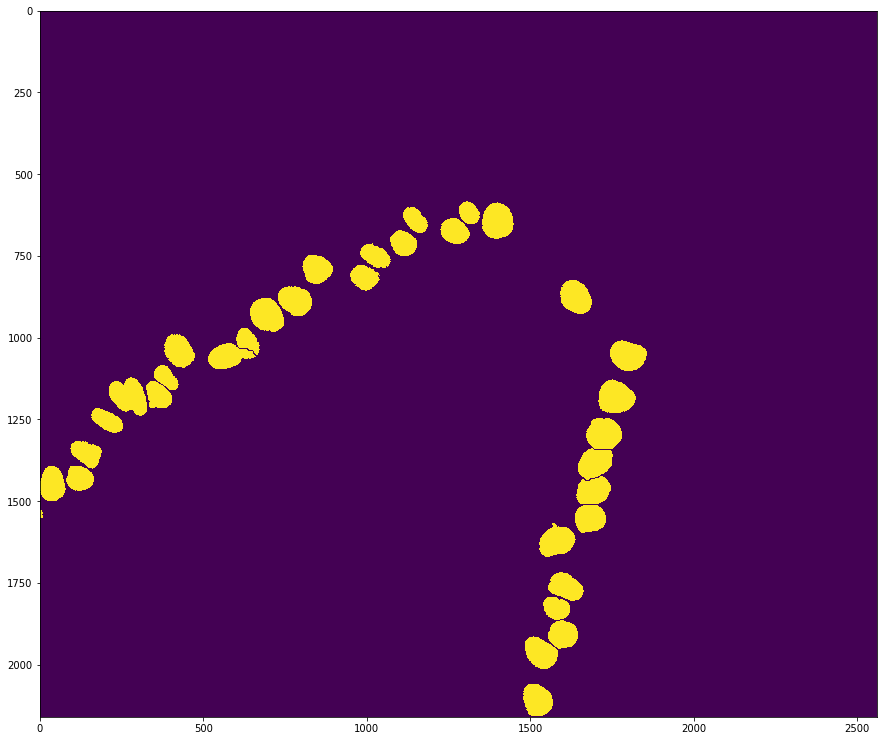

In [9]:
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['isEdge']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)


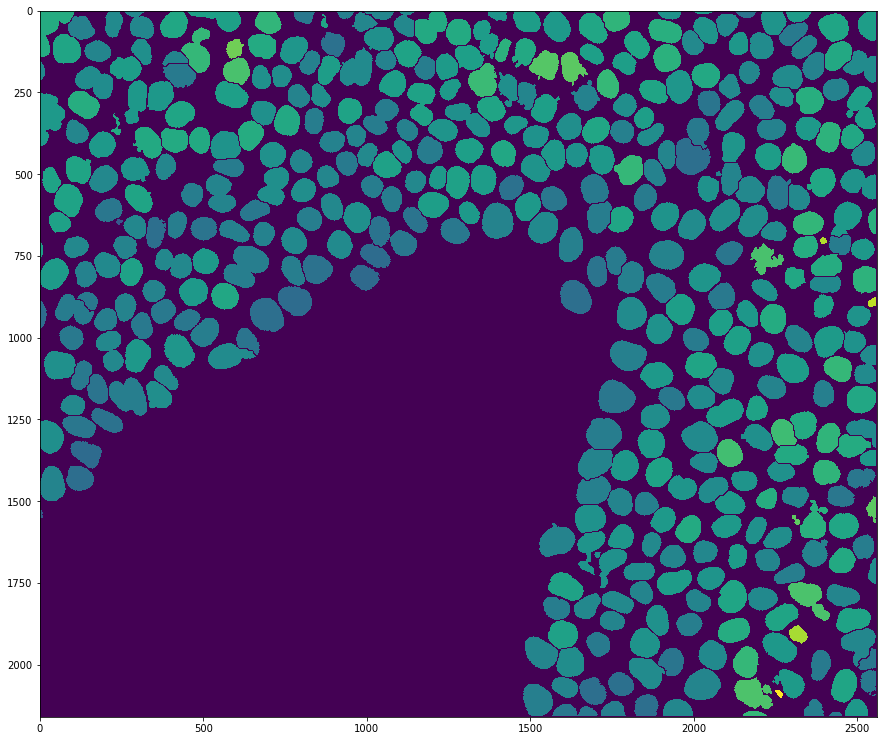

In [12]:
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['Intensity_mean_dapi.rescaled_image']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)

In [31]:
# Calculate average spot counts per well 
# print(results_cleaned.groupby('well_name')['mRNA_Count'].median())
# print(results_cleaned.groupby('well_name')['mRNA_Pbody_Count'].mean())

In [27]:
# Look at percentage of transcripts in P-bodies
# results_cleaned = results_cleaned.assign(percentage_pbody_2 = 0)
# cells_with_pbodies = results_cleaned['mRNA_Count'] >= 1
# results_cleaned.loc[cells_with_pbodies,'percentage_pbody'] = results_cleaned['mRNA_Pbody_Count'][cells_with_pbodies]/results_cleaned['mRNA_Count'][cells_with_pbodies]
# print(results_cleaned['percentage_pbody'].describe())


In [28]:
# fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
# fig1.suptitle('mRNA Spot counts', fontsize = 20)
# g = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hela_C_row], ax=ax1[0])
# g.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
# h = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hek_E_row], ax=ax1[1])
# h.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])


In [29]:
# Plot percentage P-bodies vs cellular features (area, #Pbodies total, DNA content, protein content)
# fig1, ax1 = plt.subplots(2, 2, figsize=(15, 15))
# fig1.suptitle('Percentage Pbodies vs. cell Features', fontsize = 20)
# SPEN_hek = results_cleaned['well_name'] == 'E09'
# sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)

# CCND1_hela = results_cleaned['well_name'] == 'C05'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)

# lamp1_hela = results_cleaned['well_name'] == 'C04'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)


In [20]:
# Save dataframe as csv
# results_cleaned.to_csv('20181203-bDNA-FISH8-results-cleaned_improved.csv')

Load data directly from TissueMaps for single wells

In [30]:
# import tmclient
# host="172.23.47.46"
# port = 80
# experimentName="20181203-bDNA-FISH-8"
# username="joel"
# password="123456"
# mapobject="Cells"
# client = tmclient.TmClient(host, port, username, password, experimentName)

# plateDownload = client.get_plates()
# plate_name = plateDownload[0]['name']

# wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'E03', 'E08']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T1_Count_bDNA-FISH'].mean())
# #         print(feature_values['mRNA_Pbody_T1_Count'].mean())

# wells = ['C09', 'C10']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T4_Count_bDNA-FISH'].mean()) 